# PARAMETER ESTIMATION

In [ ]:
# Importing Libraries

import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt

''' GEKKO is a Python package for machine learning and optimization of mixed-integer and differential algebraic equations. 
It is coupled with large-scale solvers for linear, quadratic, nonlinear, and mixed integer programming (LP, QP, NLP, MILP, MINLP). 
Modes of operation include parameter regression, data reconciliation, real-time optimization, dynamic simulation, and nonlinear predictive control.'''
from gekko import GEKKO   

# SysIdentPy is a System Identification library in Python!
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.metrics import root_relative_squared_error
from sklearn.model_selection import train_test_split

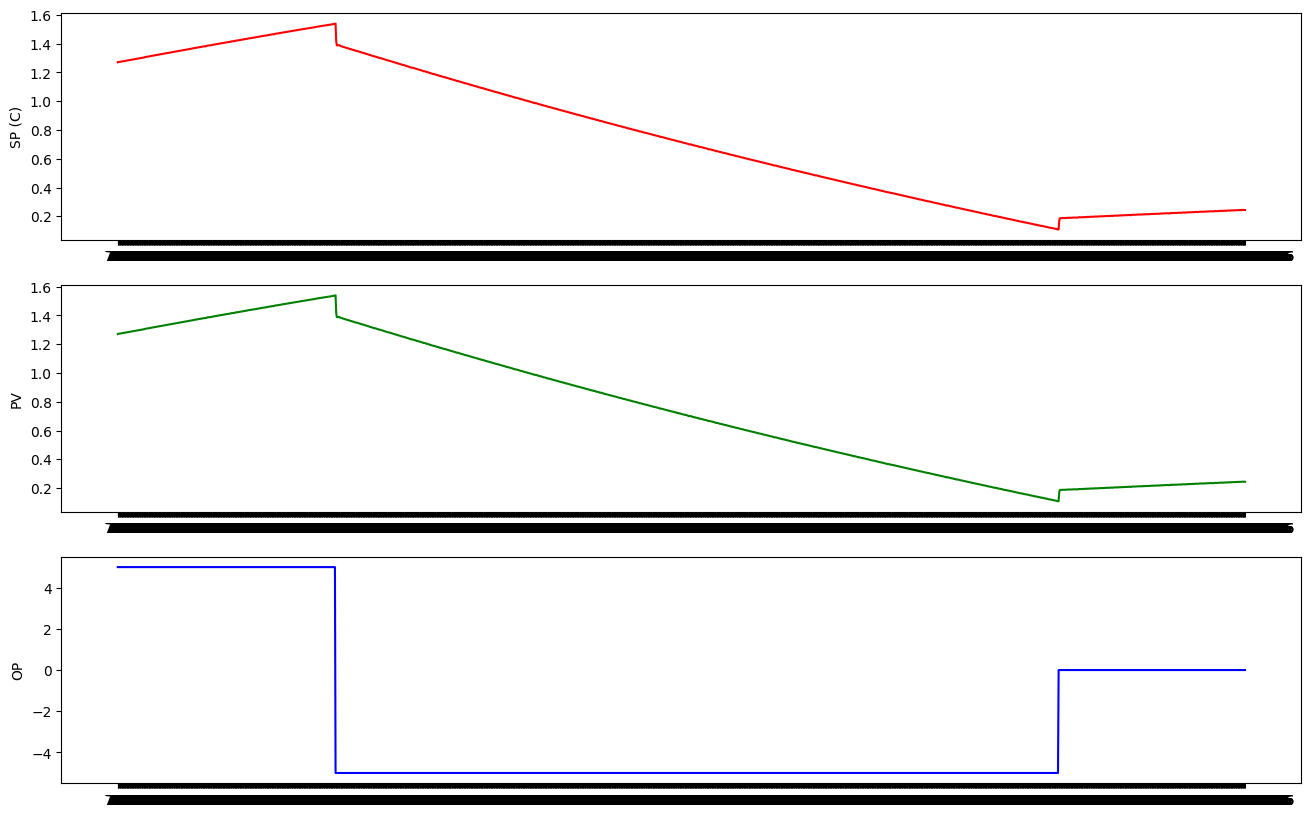

In [132]:
# Importing Step test data from UNISIM

df = pd.read_csv("D:/TH_Koeln/Case Studies/MPC/April Update/PRBS Tests/Batch_1_day_runs.csv", skiprows=9, header=0)
df.drop(labels=0, axis=0, inplace=True)
df.drop(df.columns[-1], axis=1, inplace=True)
df.astype(float)



# Deleting Stationary point data
df['TC Compressor - OP'] = df['TC Compressor - OP'].astype(float) - 63
df['TC Compressor - PV'] = df['TC Compressor - PV'].astype(float) - 33
df['TC Compressor - SP'] = df['TC Compressor - SP'].astype(float) - 33
df = df.drop(df.index[:3])


# Visualizing the data
plt.figure(figsize=(16,10))
plt.subplot(3,1,1)
plt.plot(df['Time'],df['TC Compressor - SP'],'r')
plt.ylabel('SP (C)')
plt.subplot(3,1,2)
plt.plot(df['Time'],df['TC Compressor - PV'],'g')
plt.ylabel('PV')
plt.subplot(3,1,3)
plt.plot(df['Time'],df['TC Compressor - OP'],'b')
plt.ylabel('OP')
plt.show()

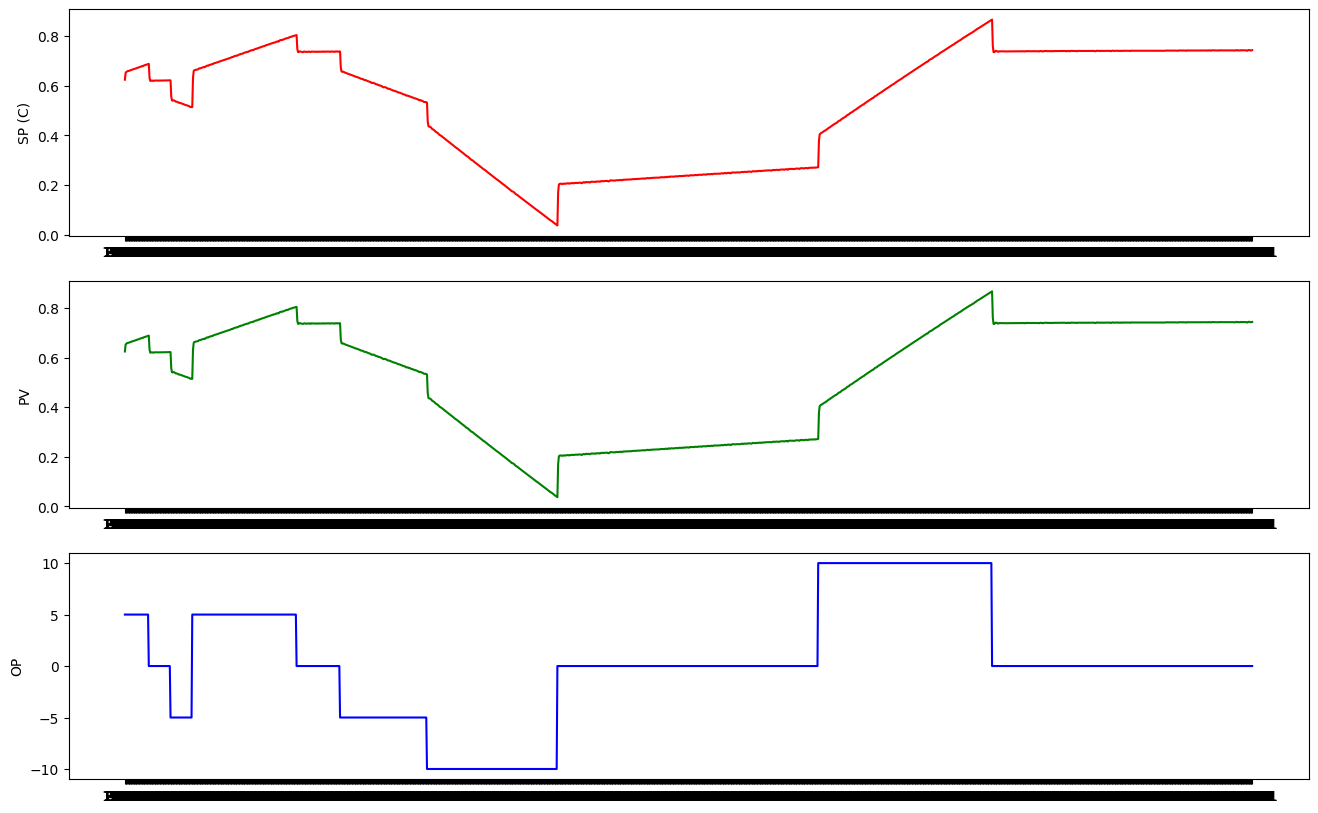

In [133]:
df1 = pd.read_csv("D:/TH_Koeln/Case Studies/MPC/April Update/PRBS Tests/Batch_1.csv", skiprows=9, header=0)
df1.drop(labels=0, axis=0, inplace=True)
df1.astype(float)


#delete row 1 2 and 3
df1['TC Compressor - OP'] = df1['TC Compressor - OP'].astype(float) - 63
df1['TC Compressor - PV'] = df1['TC Compressor - PV'].astype(float) - 33
df1['TC Compressor - SP'] = df1['TC Compressor - SP'].astype(float) - 33
df1 = df1.drop(df1.index[:3])


plt.figure(figsize=(16,10))
plt.subplot(3,1,1)
plt.plot(df1['Time'],df1['TC Compressor - SP'],'r')
plt.ylabel('SP (C)')
plt.subplot(3,1,2)
plt.plot(df1['Time'],df1['TC Compressor - PV'],'g')
plt.ylabel('PV')
plt.subplot(3,1,3)
plt.plot(df1['Time'],df1['TC Compressor - OP'],'b')
plt.ylabel('OP')
plt.show()

In [127]:


t_data = df['Time'].values
u_data = df['TC Compressor - OP'].values
y_data = df['TC Compressor - PV'].values

m = GEKKO(remote=False)
m.time = t_data 
# Create variables
u = m.Param(value=u_data)  # Input data (manipulated variable)
y = m.CV(value=y_data)     # Output data (controlled variable)
y.FSTATUS = 1 
Ti = m.FV(value=1.0, lb=1, ub=100000000)  # Initial guess for Ti, with lower and upper bounds
Ti.STATUS = 1  # adjustable parameter
# Define the integrator model equation
m.Equation(y.dt() == 1 / Ti * u)
# Set options for dynamic estimation
m.options.IMODE = 5
m.options.NODES = 5

# Solve the optimization problem
m.solve(disp=False)

Ti_optimized = Ti.value[0]


In [128]:
Ti_optimized

1118361.5977

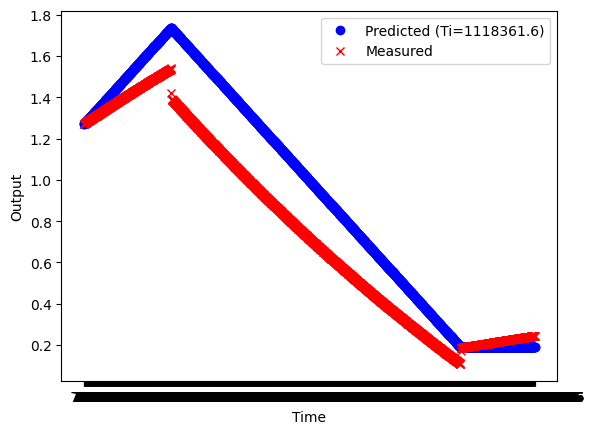

In [130]:


# Plot the results
plt.plot(m.time, y.value, 'bo', label=f'Predicted (Ti={np.round(Ti_optimized, 2)})')
plt.plot(m.time, y_data, 'rx', label='Measured')
plt.xlabel('Time')
plt.ylabel('Output')
plt.legend()
plt.show()

In [123]:
from gekko import GEKKO 

t_data = df1['Time'].values
y_data = df1['TC Compressor - OP'].values
u_data = df1['TC Compressor - PV'].values

m = GEKKO(remote=False)
m.time = t_data 
# Create variables
u = m.Param(value=u_data)  # Input data (manipulated variable)
y = m.CV(value=y_data)     # Output data (controlled variable)
y.FSTATUS = 1 
Ti = m.FV(value=1.0, lb=1, ub=100000000)  # Initial guess for Ti, with lower and upper bounds
Ti.STATUS = 1  # adjustable parameter
# Define the integrator model equation
m.Equation(y.dt() == 1 / Ti * u)
# Set options for dynamic estimation
m.options.IMODE = 5
m.options.NODES = 5

# Solve the optimization problem
m.solve(disp=False)

Ti_optimized = Ti.value[0]

In [125]:
Ti_optimized

1346367.9845

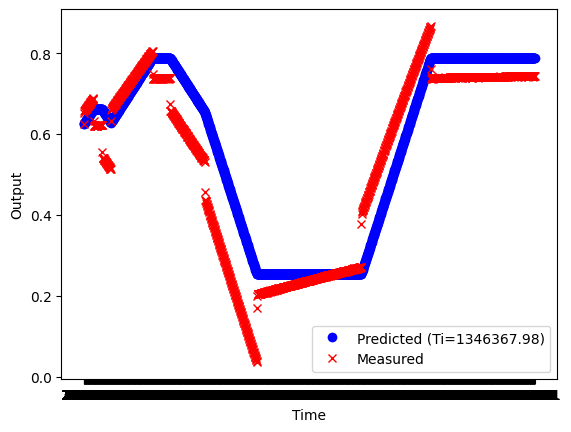

In [124]:


# Plot the results
plt.plot(m.time, y.value, 'bo', label=f'Predicted (Ti={np.round(Ti_optimized, 2)})')
plt.plot(m.time, y_data, 'rx', label='Measured')
plt.xlabel('Time')
plt.ylabel('Output')
plt.legend()
plt.show()

SysIdentPy

In [160]:


# Assuming df1 contains the time, input, and output data
t_data = df1['Time'].values
y_data = df1['TC Compressor - OP'].values
u_data = df1['TC Compressor - PV'].values

# Split the data into training and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(u_data, y_data, test_size=0.2, random_state=42)

# Create an FROLS object
model = FROLS(n_terms=2, estimator='total_least_squares')

# Perform system identification
model.fit(x_train, y_train)

# Extract the estimated parameters
Ti_estimated = model.model.structure.model_parameters['input_output']['K']


TypeError: FROLS.fit() takes 1 positional argument but 3 were given